# GANs
In this project, we will first implement the original GAN and the Wasserstein GAN (WGAN) on a toy problem to see how the relatively small changes can lead to big changes during training. Then, we will train a Conditional GAN (cGAN) on MNIST.

## Setup

```
conda env create -f environments/environment-gpu.yml
```

or

```
conda env create -f environments/environment-cpu-only.yml
```


---

In [1]:
import os
import os.path as osp
import numpy as np
import time
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(1337)
np.random.seed(1337)


# Part 2: Conditional GAN
When using GANs, it could be very useful to generate a particular type of images from the full data distribution. In this part, we will implement a conditional GAN (cGAN) that can generate images of specific hand-written digits using the MNIST dataset.

Initially, we want you to implement the conditional generator. It should be a MLP with the follwing architecture:
- An input node that takes the concatenated noise vector and the embedded label as input.
- A LeakyReLU layer with a slope of 0.2.
- 3 fully connected layers with 256, 512 and 1024 nodes respectively, which all should be follwed by a BatchNorm and a LeakyReLU activation.
- An output layer with im_height * im_width * im_channels nodes and a Tanh activation.

The forward pass should: 
- Embed the label
- Concatenate the noise vector and the embedded label.
- Pass the concatenated vector through the MLP.
- Reshape the output to the correct image size.

In [22]:
class ConditionalGenerator(nn.Module):
    def __init__(self, n_classes: int, n_channels: int, img_size: int, latent_dim: int):
        super(ConditionalGenerator, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.n_channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.n_classes, self.n_classes)

        # YOUR CODE HERE
        self.net = nn.Sequential(
            nn.Linear(self.latent_dim+self.n_classes, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_channels*self.img_size**2)
        )

    def forward(self, noise: torch.Tensor, labels: torch.Tensor):
        """Generates an image given a noise vector and a label.

        Args:
            noise (torch.Tensor): A noise vector of shape (batch_size, latent_dim)
            labels (torch.Tensor): A label vector of shape (batch_size)
        Returns:
            torch.Tensor: A generated image of shape (batch_size, n_channels, img_size, img_size)
        """
        embedded_labels = self.label_embedding(labels)
        x_flat = self.net(torch.concat([noise, embedded_labels], dim=1))
        x_img = x_flat.view(x_flat.size(0), self.n_channels, self.img_size, self.img_size) 

        return x_img

In [23]:
tmp_generator = ConditionalGenerator(10, 1, 28, 100)
tmp_noise = torch.randn(10, 100)
tmp_labels = torch.randint(0, 10, (10,))
tmp_img = tmp_generator(tmp_noise, tmp_labels)
assert tmp_img.shape == (10, 1, 28, 28), "Wrong shape of generated image"

Here, we want to implement the conditional discriminator. It should be a MLP with the follwing architecture:
- An input node that takes the flattened image concatenated with the embedded label as input, and outputs 1024 nodes.
- A LeakyReLU layer with a slope of 0.2.
- 2 fully connected layers with 512 and 256 respectively, both followed by a Dropout layer with a probability of 0.4 and a LeakyReLU activation.
- 1 fully connected layer with 128 nodes.
- 1 output layer with 1 node follwed by a Sigmoid activation.

The forward pass should:
- Embed the label
- Concatenate the image and the embedded label.
- Pass the concatenated vector through the MLP.
- Return the output.


In [37]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes: int, n_channels: int, img_size: int):
        super(ConditionalDiscriminator, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.img_size = img_size
        self.img_shape = (self.n_channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.n_classes, self.n_classes)
        self.adv_loss = torch.nn.BCELoss()

        self.net = nn.Sequential(
            nn.Linear(self.n_channels*self.img_size**2+self.n_classes, 1024),
            nn.Dropout1d(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.Dropout1d(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Dropout1d(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, image: torch.Tensor, labels: torch.Tensor):
        """Classifies an image given a label.

        Args:
            image (torch.Tensor): An image of shape (batch_size, n_channels, img_size, img_size)
            labels (torch.Tensor): A label vector of shape (batch_size)
        Returns:
            torch.Tensor: A classification score of shape (batch_size)
        """
        embedded_labels = self.label_embedding(labels)
        ll = torch.concat([image.flatten(start_dim=1), embedded_labels], dim=1)
        x = self.net(torch.concat([image.flatten(start_dim=1), embedded_labels], dim=1))
        return x

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [38]:
tmp_discriminator = ConditionalDiscriminator(10, 1, 28)
tmp_img = torch.randn(10, 1, 28, 28)
tmp_labels = torch.randint(0, 10, (10,))
tmp_score = tmp_discriminator(tmp_img, tmp_labels)
assert tmp_score.shape == (10, 1), "Wrong shape of classification score"

To train the model, we have provided you with a training loop below. However, feel free to play around with it.

In [44]:
class ConditionalGan:
    def __init__(
        self,
        device: str,
        data_loader: torch.utils.data.DataLoader,
        n_classes: int,
        n_channels: int,
        img_size: int,
        latent_dim: int,
    ):
        self.device = device
        self.data_loader = data_loader
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.generator = ConditionalGenerator(
            self.n_classes, self.n_channels, self.img_size, self.latent_dim
        )
        self.generator.to(self.device)
        self.discriminator = ConditionalDiscriminator(
            self.n_classes, self.n_channels, self.img_size
        )
        self.discriminator.to(self.device)
        self.optim_G = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.generator.parameters()),
            lr=1e-4,
            betas=(0.5, 0.999),
        )
        self.optim_D = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.discriminator.parameters()),
            lr=1e-4,
            betas=(0.5, 0.999),
        )

    def train(self, n_epochs: int, log_interval: int = 200):
        self.generator.train()
        self.discriminator.train()
        viz_noise = torch.randn(10, self.latent_dim).to(self.device)
        viz_labels = torch.arange(10).to(self.device)

        for epoch in range(n_epochs):
            batch_time = time.time()
            for batch_idx, (data, target) in enumerate(self.data_loader):
                data, target = data.to(self.device), target.to(self.device)
                batch_size = data.size(0)
                real_label = torch.full((batch_size, 1), 1.0, device=self.device)
                fake_label = torch.full((batch_size, 1), 0.0, device=self.device)

                # train generator
                self.generator.zero_grad()
                z_noise = torch.randn(batch_size, self.latent_dim, device=self.device)
                x_fake_labels = torch.randint(
                    0, self.n_classes, (batch_size,), device=self.device
                )
                x_fake = self.generator(z_noise, x_fake_labels)
                y_fake_g = self.discriminator(x_fake, x_fake_labels)
                g_loss = self.discriminator.loss(y_fake_g, real_label)
                g_loss.backward()
                self.optim_G.step()

                # train discriminator
                self.discriminator.zero_grad()
                y_real = self.discriminator(data, target)
                d_real_loss = self.discriminator.loss(y_real, real_label)
                y_fake_d = self.discriminator(x_fake.detach(), x_fake_labels)
                d_fake_loss = self.discriminator.loss(y_fake_d, fake_label)
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                self.optim_D.step()

                if batch_idx % log_interval == 0 and batch_idx > 0:
                    _, axs = plt.subplots(1, 10, figsize=(15, 15))
                    with torch.no_grad():
                        generated_images = self.generator(viz_noise, viz_labels)
                    for i in range(10):
                        axs[i].imshow(generated_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
                        axs[i].axis("off")
                    plt.show()

                    print(
                        "Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}".format(
                            epoch,
                            batch_idx,
                            len(self.data_loader),
                            d_loss.mean().item(),
                            g_loss.mean().item(),
                            time.time() - batch_time,
                        )
                    )

                    batch_time = time.time()

Define the training. Feel free to experiment with both the architecture and the hyperparameters, however, the model should be able to generate images that look like the ones in the dataset. 

Using device: cuda
Loading data...

Creating model...



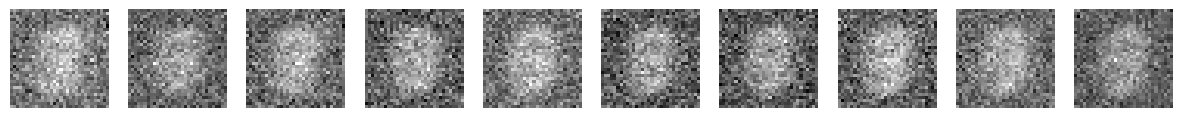

Epoch 0 [200/469] loss_D: 0.6843 loss_G: 0.7680 time: 2.60


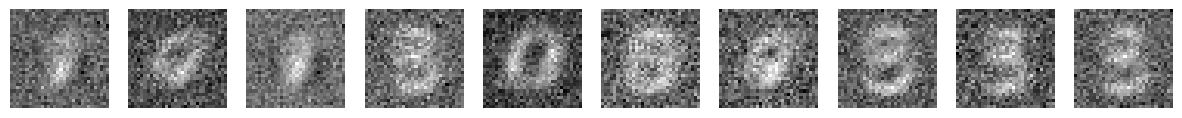

Epoch 0 [400/469] loss_D: 0.6779 loss_G: 0.8016 time: 1.58


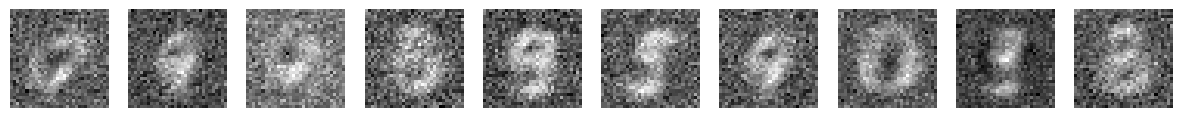

Epoch 1 [200/469] loss_D: 0.6479 loss_G: 0.8171 time: 2.52


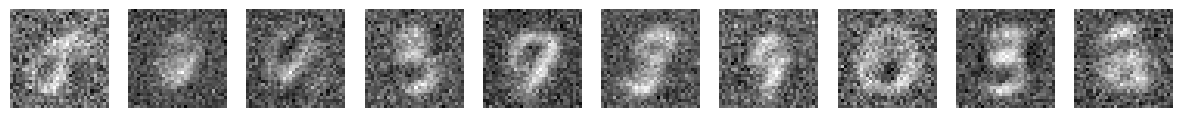

Epoch 1 [400/469] loss_D: 0.6750 loss_G: 0.6999 time: 1.72


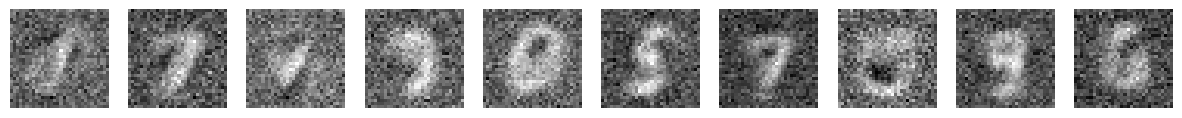

Epoch 2 [200/469] loss_D: 0.6620 loss_G: 0.8157 time: 2.51


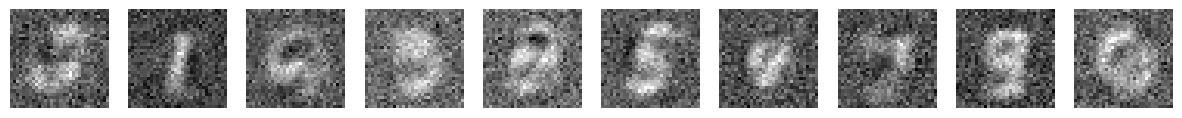

Epoch 2 [400/469] loss_D: 0.6850 loss_G: 0.6697 time: 1.69


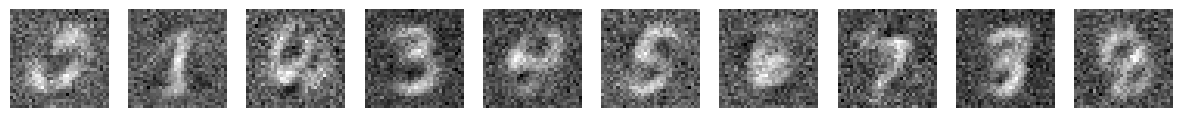

Epoch 3 [200/469] loss_D: 0.6348 loss_G: 0.8470 time: 2.31


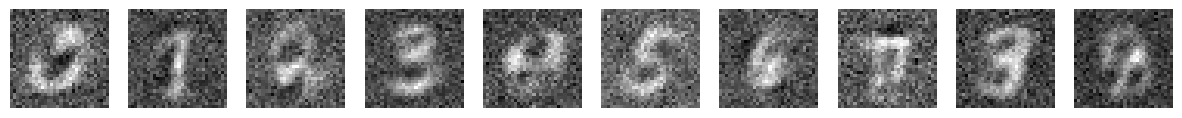

Epoch 3 [400/469] loss_D: 0.6290 loss_G: 0.7448 time: 1.72


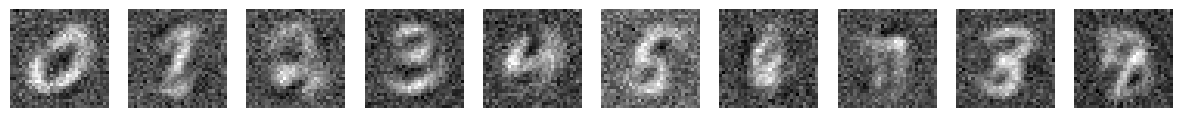

Epoch 4 [200/469] loss_D: 0.6465 loss_G: 0.7239 time: 2.44


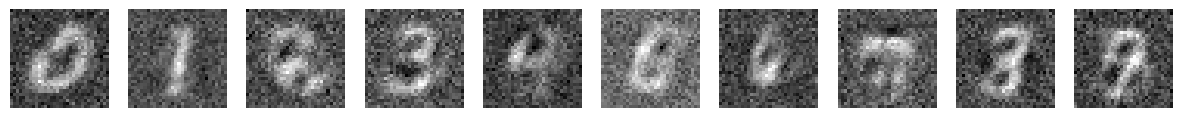

Epoch 4 [400/469] loss_D: 0.6352 loss_G: 0.8118 time: 1.71


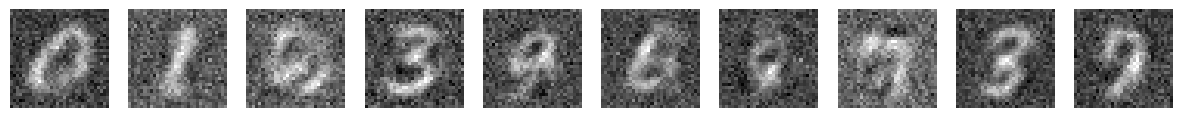

Epoch 5 [200/469] loss_D: 0.6461 loss_G: 0.9753 time: 2.40


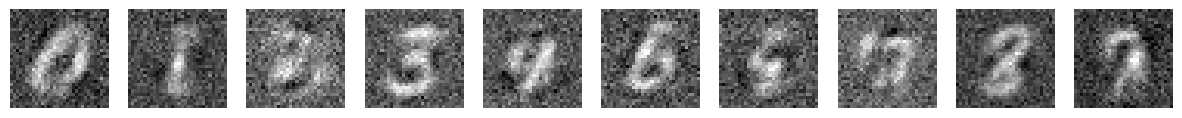

Epoch 5 [400/469] loss_D: 0.6634 loss_G: 0.8912 time: 1.58


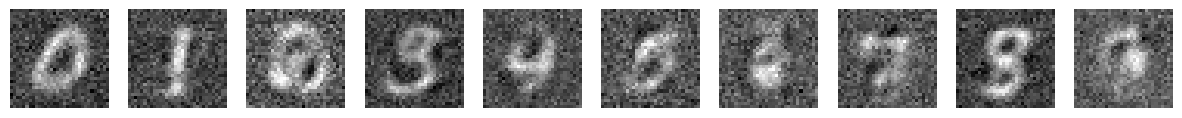

Epoch 6 [200/469] loss_D: 0.6590 loss_G: 0.7532 time: 2.48


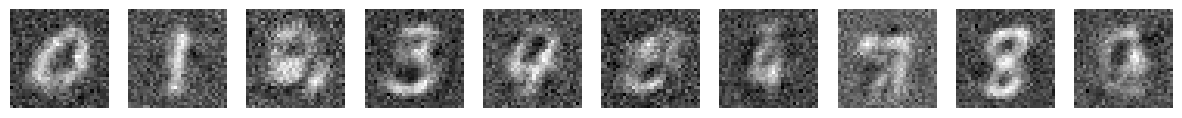

Epoch 6 [400/469] loss_D: 0.6291 loss_G: 0.8139 time: 1.76


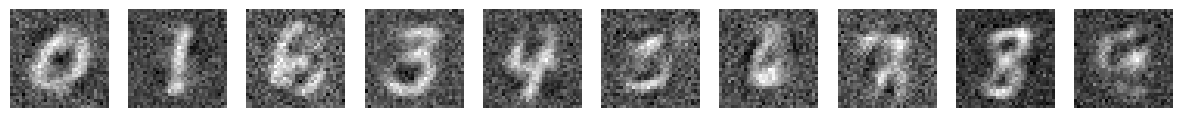

Epoch 7 [200/469] loss_D: 0.6451 loss_G: 0.8267 time: 2.52


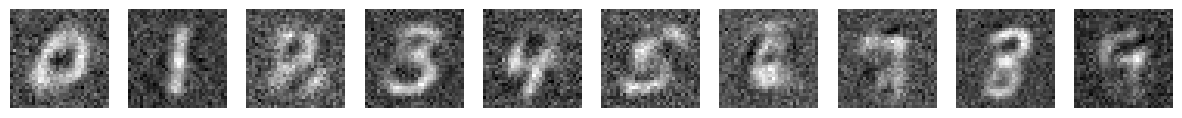

Epoch 7 [400/469] loss_D: 0.6323 loss_G: 1.1150 time: 1.77


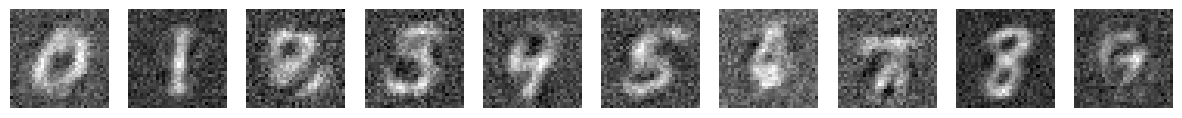

Epoch 8 [200/469] loss_D: 0.6411 loss_G: 0.8112 time: 2.51


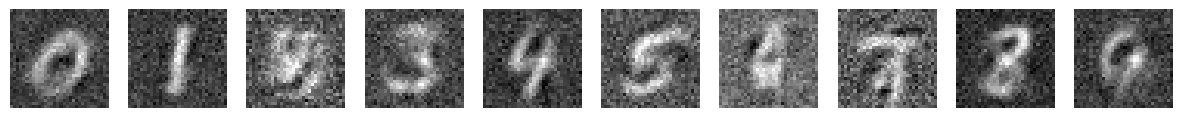

Epoch 8 [400/469] loss_D: 0.7020 loss_G: 0.9477 time: 1.72


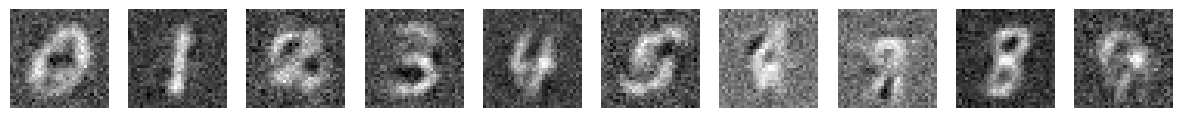

Epoch 9 [200/469] loss_D: 0.6691 loss_G: 0.7284 time: 2.63


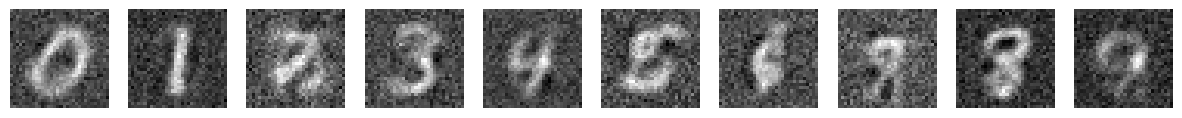

Epoch 9 [400/469] loss_D: 0.6057 loss_G: 1.1258 time: 1.67


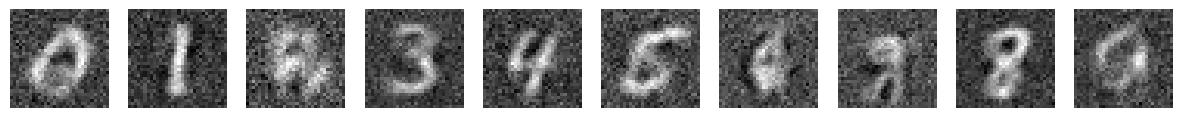

Epoch 10 [200/469] loss_D: 0.6156 loss_G: 0.8377 time: 2.46


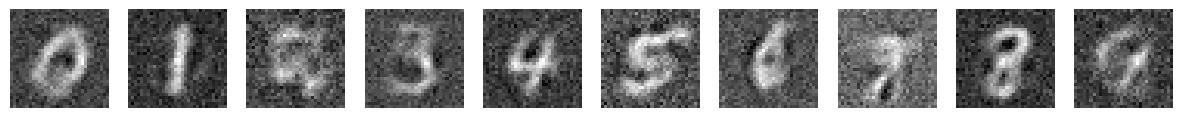

Epoch 10 [400/469] loss_D: 0.6614 loss_G: 0.7161 time: 1.67


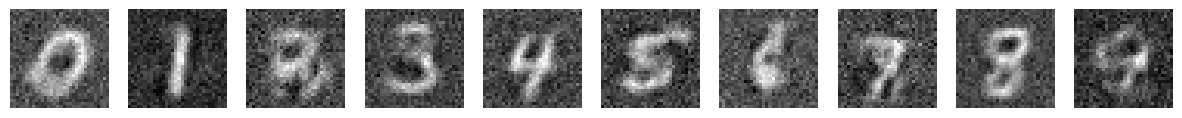

Epoch 11 [200/469] loss_D: 0.6811 loss_G: 0.7948 time: 2.55


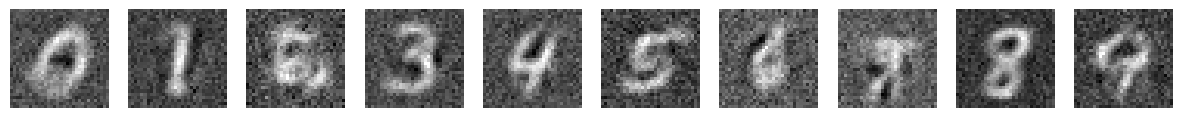

Epoch 11 [400/469] loss_D: 0.6458 loss_G: 0.7319 time: 1.73


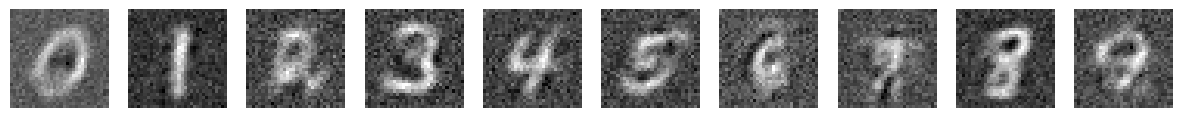

Epoch 12 [200/469] loss_D: 0.6752 loss_G: 0.9101 time: 2.63


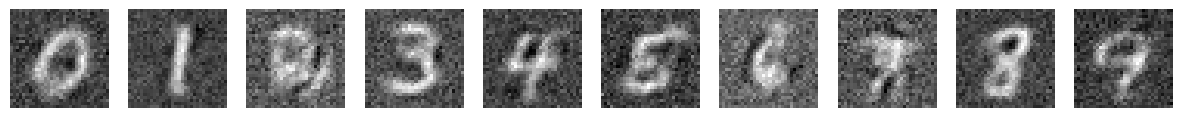

Epoch 12 [400/469] loss_D: 0.6812 loss_G: 0.7161 time: 1.71


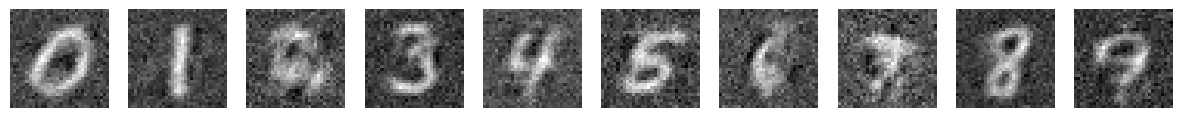

Epoch 13 [200/469] loss_D: 0.6626 loss_G: 0.8090 time: 2.65


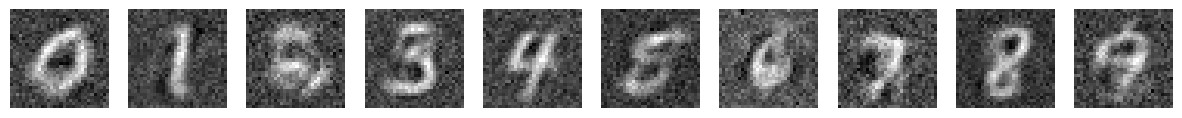

Epoch 13 [400/469] loss_D: 0.6690 loss_G: 0.8955 time: 1.70


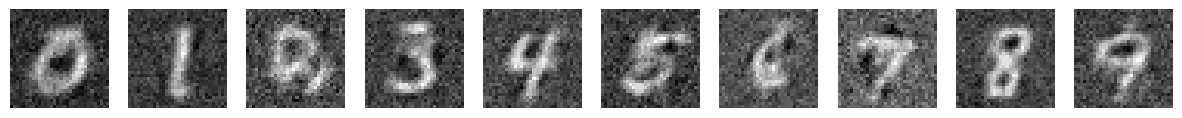

Epoch 14 [200/469] loss_D: 0.6693 loss_G: 0.8114 time: 2.65


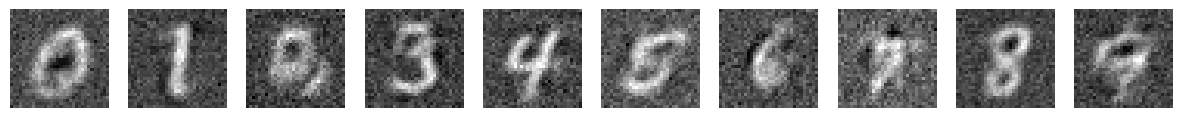

Epoch 14 [400/469] loss_D: 0.6733 loss_G: 0.9031 time: 1.83


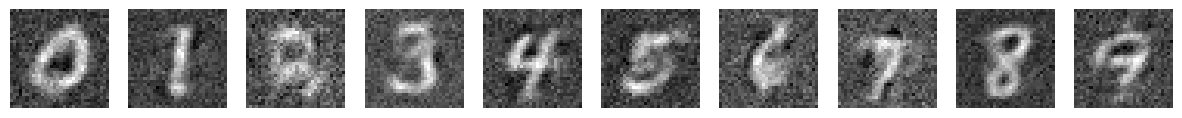

Epoch 15 [200/469] loss_D: 0.6410 loss_G: 0.7715 time: 2.56


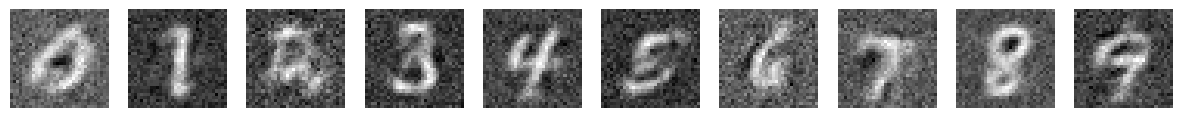

Epoch 15 [400/469] loss_D: 0.6684 loss_G: 0.9176 time: 1.78


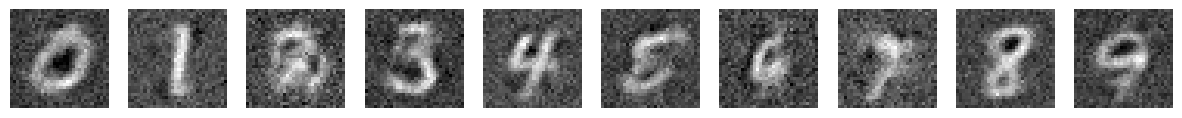

Epoch 16 [200/469] loss_D: 0.7059 loss_G: 0.9536 time: 2.34


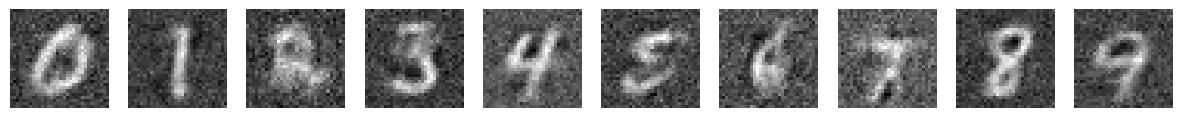

Epoch 16 [400/469] loss_D: 0.6444 loss_G: 0.7471 time: 1.59


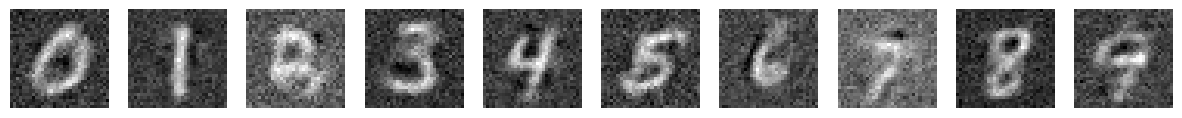

Epoch 17 [200/469] loss_D: 0.6744 loss_G: 0.8185 time: 2.48


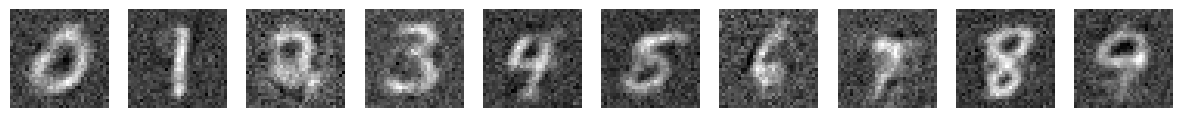

Epoch 17 [400/469] loss_D: 0.6364 loss_G: 0.7696 time: 1.88


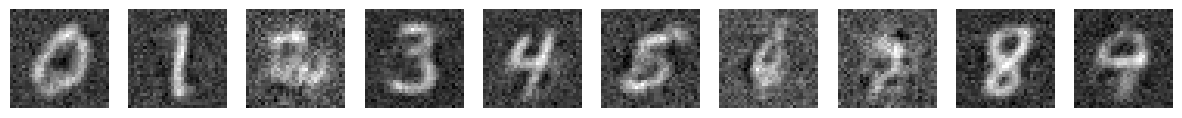

Epoch 18 [200/469] loss_D: 0.6571 loss_G: 0.7541 time: 2.28


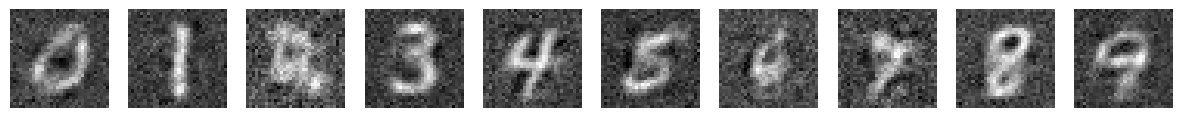

Epoch 18 [400/469] loss_D: 0.6612 loss_G: 0.7618 time: 1.57


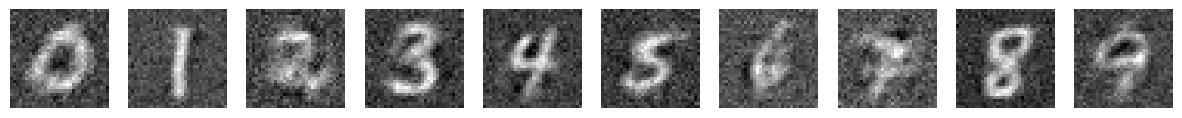

Epoch 19 [200/469] loss_D: 0.6298 loss_G: 0.7860 time: 2.36


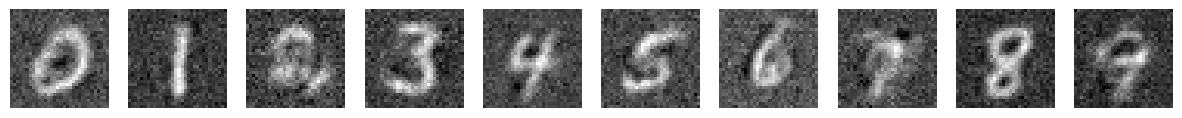

Epoch 19 [400/469] loss_D: 0.6333 loss_G: 0.8015 time: 1.59


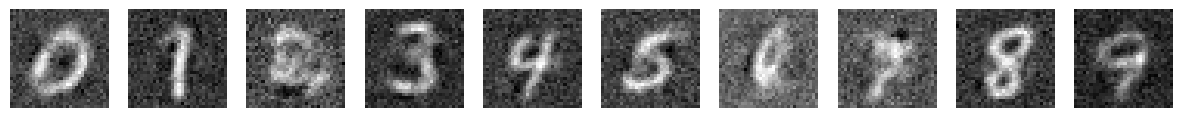

Epoch 20 [200/469] loss_D: 0.6205 loss_G: 0.9398 time: 2.29


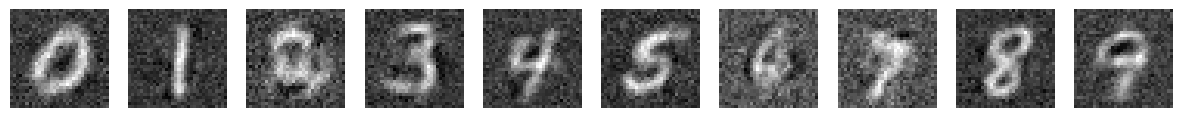

Epoch 20 [400/469] loss_D: 0.6190 loss_G: 1.0305 time: 1.72


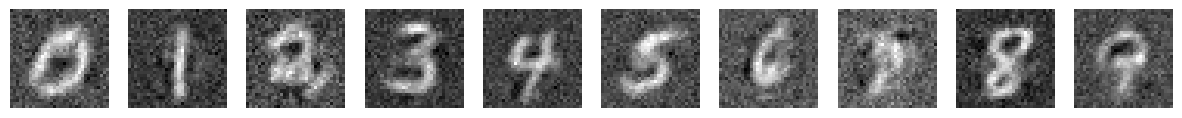

Epoch 21 [200/469] loss_D: 0.6503 loss_G: 0.7764 time: 2.28


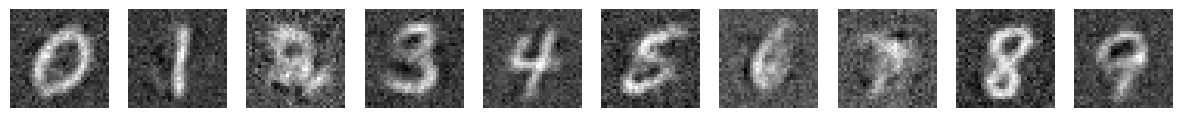

Epoch 21 [400/469] loss_D: 0.6107 loss_G: 0.8347 time: 1.66


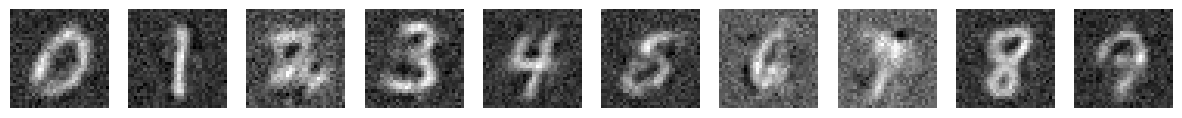

Epoch 22 [200/469] loss_D: 0.6713 loss_G: 0.9136 time: 2.27


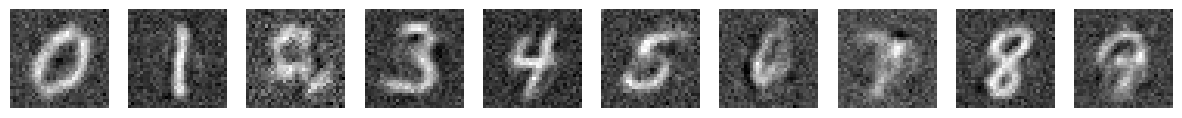

Epoch 22 [400/469] loss_D: 0.6379 loss_G: 0.7281 time: 1.57


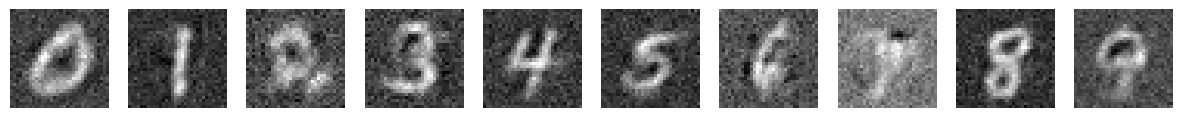

Epoch 23 [200/469] loss_D: 0.6322 loss_G: 0.9161 time: 2.28


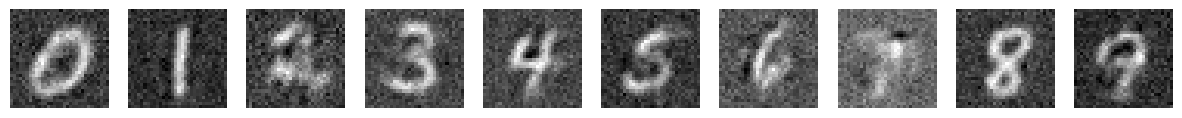

Epoch 23 [400/469] loss_D: 0.6849 loss_G: 0.9611 time: 1.87


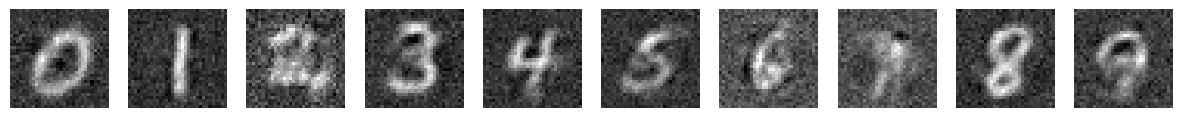

Epoch 24 [200/469] loss_D: 0.6354 loss_G: 1.0240 time: 2.44


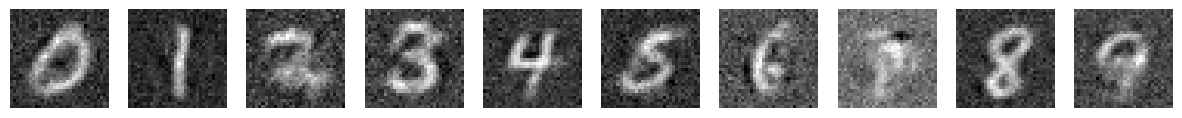

Epoch 24 [400/469] loss_D: 0.6141 loss_G: 1.0099 time: 1.62


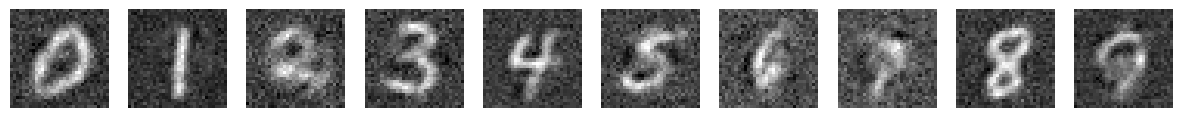

Epoch 25 [200/469] loss_D: 0.6382 loss_G: 0.8184 time: 2.59


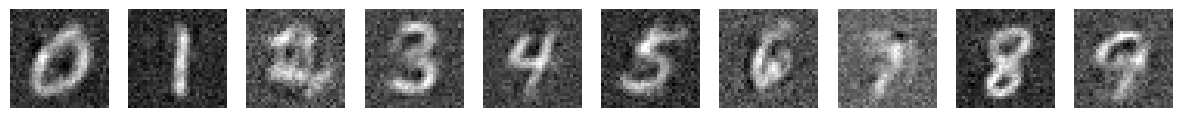

Epoch 25 [400/469] loss_D: 0.6077 loss_G: 0.9084 time: 1.66


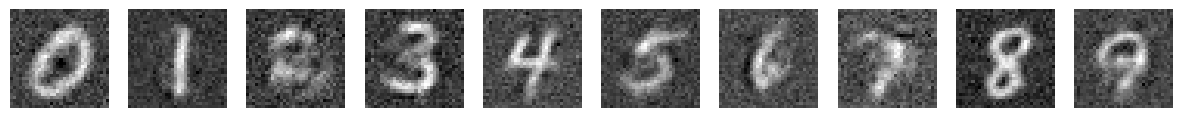

Epoch 26 [200/469] loss_D: 0.5899 loss_G: 1.0609 time: 2.28


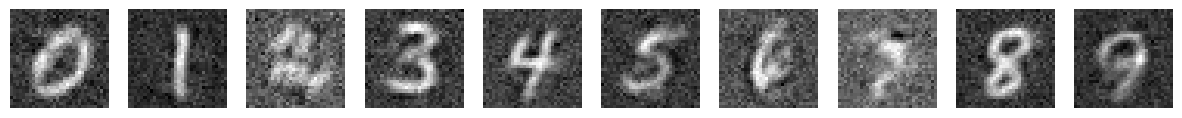

Epoch 26 [400/469] loss_D: 0.6220 loss_G: 0.7853 time: 1.76


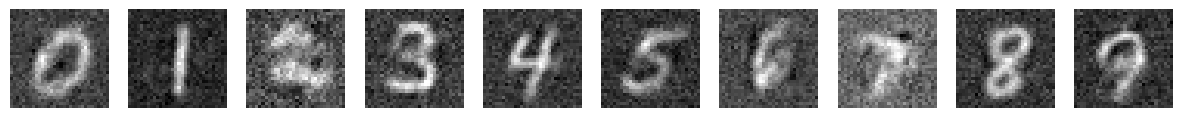

Epoch 27 [200/469] loss_D: 0.6231 loss_G: 0.9333 time: 2.30


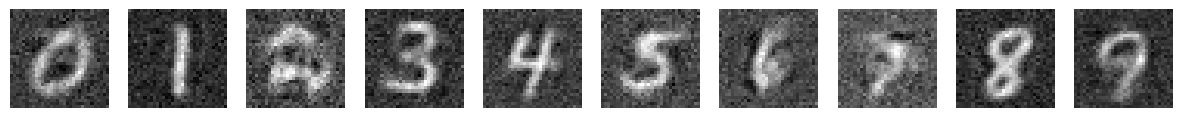

Epoch 27 [400/469] loss_D: 0.6270 loss_G: 0.7633 time: 1.65


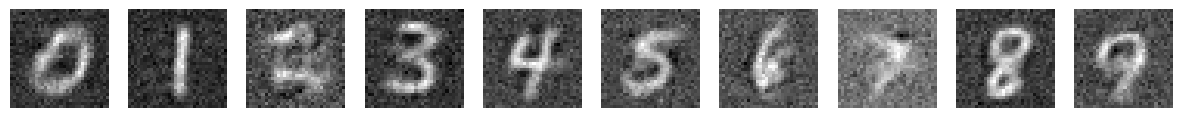

Epoch 28 [200/469] loss_D: 0.6244 loss_G: 0.9153 time: 2.42


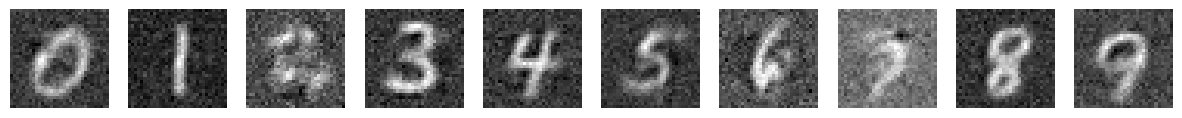

Epoch 28 [400/469] loss_D: 0.6197 loss_G: 0.8928 time: 1.65


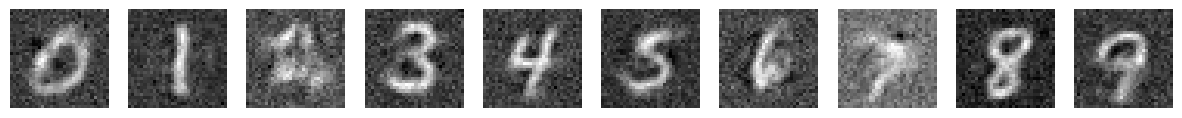

Epoch 29 [200/469] loss_D: 0.6279 loss_G: 1.0563 time: 2.78


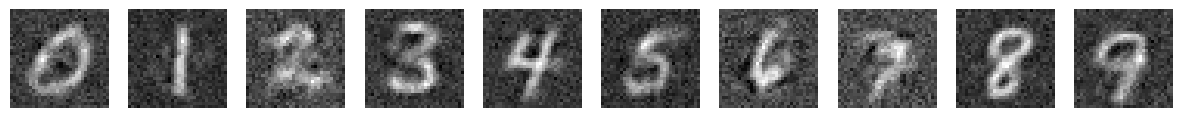

Epoch 29 [400/469] loss_D: 0.6459 loss_G: 0.8742 time: 1.59


In [45]:
MNIST_DATA_DIR = "./mnist_data"
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
EPOCHS = 30
IMG_SIZE = 32
BATCH_SIZE = 128
LATENT_DIM = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: {}".format(DEVICE))

print("Loading data...\n")
dataset = dset.MNIST(
    root=MNIST_DATA_DIR,
    download=True,
    transform=transforms.Compose(
        [
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
)
assert dataset
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
print("Creating model...\n")
model = ConditionalGan(
    device=DEVICE,
    data_loader=dataloader,
    n_classes=10,
    n_channels=1,
    img_size=IMG_SIZE,
    latent_dim=LATENT_DIM,
)

# Train
model.train(n_epochs=EPOCHS, log_interval=200)

Now that we've trained the model, let's see how it performs. We can use the following function to generate images from the generator and see if they look similar to the ones in the dataset.

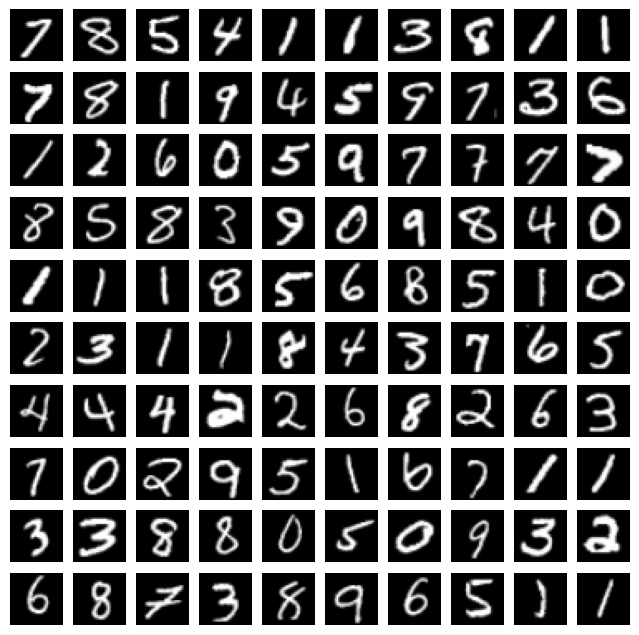

Can you tell the difference?


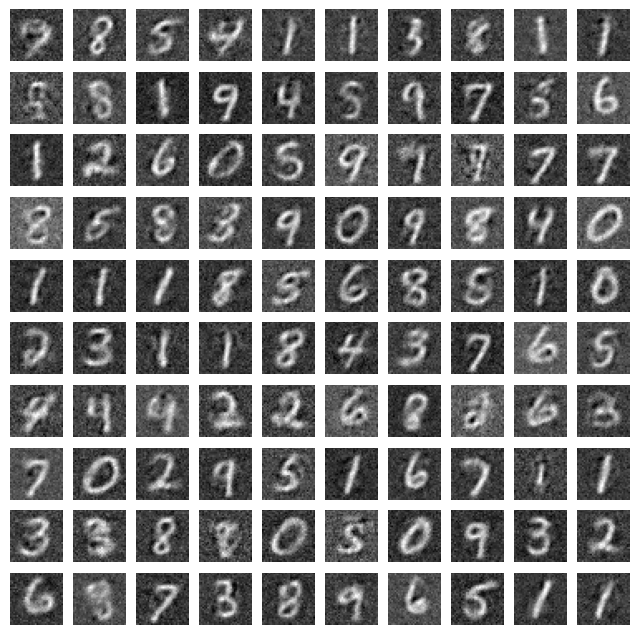

In [48]:

# show some real data 
images, labels = next(iter(dataloader))
images = images[:100]
labels = labels[:100].to(DEVICE)
fig, axs = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(images[i * 10 + j].squeeze(), cmap="gray")
        axs[i, j].axis("off")
plt.savefig(osp.join(OUTPUT_DIR, "real_gridview.png"))
plt.show()

# generate a 10x10 grid of images
noise = torch.randn(100, model.latent_dim).to(DEVICE)
with torch.no_grad():
    generated_images = model.generator(noise, labels)

fig, axs = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(generated_images[i * 10 + j].squeeze().detach().cpu().numpy(), cmap="gray")
        axs[i, j].axis("off")
plt.savefig(osp.join(OUTPUT_DIR, "fake_gridview.png"))

print("Can you tell the difference?")


# Looking back
Now that you've also implemented a conditional GAN, to be able to generate a particular sample from the data distrubution. As of now, you know absolutely everything there is to know about GANs, and therefore, it is time to look back at the previous project on VAEs. Here, we want you to contrast GANs to VAEs in the following aspects:
1. What are they trained to do, respectively?
2. Latent space: How are the latent spaces of GANs and VAEs different? 
3. Mode collapse: Are they equally prone to mode collapse? If not, which one is more prone?
4. Applications: What are some applications of GANs and VAEs? What can you do with a VAE that is not suitable for a GAN?
5. Quality of samples: Which one tends generate better data?



1. GANs are trained to generate images that makes it as hard as possible for a discriminator model to distinguish from the data distribution. The generated images are sampled as noise in some latent space and passed through an decoder model. The VAE is an encoder-decoder model trained with a loss that trade-offs maximizing reconstruction w.r.t. input and having a latent space structure which is as close as possible to some prior distribution.

2. The latent space of the vanilla GAN is not constrained in any way. A noise tensor of latent_dim dimensions is sampled from a normal distribution. The noise is then encoded to something that is succesful if it fools the discrimintor into predicting to be a real data. Due to mode collapse it is possible that all of latent space is collapsed into generating samples that look the same. It is also possible that different regions in latent space generate images that differ and that interpolating in the latent space can be done in some meaningful way, but there is no additional loss term that enforces this. For the VAE, there is a KL divergence loss term for the latent space distribution w.r.t. some prior distribution. This is done to make it more feasible to interpolate in the latent space.

3. Mode collapse is a known issue for vanilla GANs. For VAEs, mode collapse would mean that all inputs are being mapped to latents which are then reconstructed to output a small subset of the true data distribution. This does not happen because the reconstruction loss explicitly avoids this.

4. As suggested in q2, the VAE is possibly better if one wants to interpolate in latent space. The VAE is also easier to train, no mode collapse etc. GANs are said to be better to obtain photorealistic images. It is not clear which is best in general since both models has a lot of extensions and hacks which solves most issues.

5. Empirically, GANs seem to be able to produce better data if trained correctly.